<a href="https://colab.research.google.com/github/The19146267/Project-cuoi-ki/blob/main/Pneumonia_X_ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install texttable

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from texttable import Texttable
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, SeparableConv2D, \
    Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from IPython.display import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_folder= '/content/drive/MyDrive/Preumonia X-ray/archive/chest_xray/train/'
val_folder = '/content/drive/MyDrive/Preumonia X-ray/archive/chest_xray/val/'
test_folder = '/content/drive/MyDrive/Preumonia X-ray/archive/chest_xray/test/'

In [ ]:
BATCH_SIZE = 32
EPOCHS = 5

In [ ]:
DETECTION_CLASSES = ('NORMAL', 'PNEUMONIA')
MODEL_LOC = '../model/pneumonia_detection_cnn_model.h5'

In [ ]:
# counting the number of images for every dataset and the associated two classes (Normal and Pneumonia)
def count_images(directory_name, detection_class):
    return len(os.listdir(directory_name + detection_class))

t = Texttable()

t.add_rows([['Dataset Type', 'Normal', 'Pneumonia'], 
            ['Training', count_images(train_folder, 'NORMAL'), count_images(train_folder, 'PNEUMONIA')], 
            ['Test', count_images(test_folder, 'NORMAL'), count_images(test_folder, 'PNEUMONIA')],
            ['Validation', count_images(val_folder, 'NORMAL'), count_images(val_folder, 'PNEUMONIA')]
           ])
print(t.draw())

+--------------+--------+-----------+
| Dataset Type | Normal | Pneumonia |
+==============+========+===========+
| Training     | 1341   | 3904      |
+--------------+--------+-----------+
| Test         | 234    | 390       |
+--------------+--------+-----------+
| Validation   | 8      | 8         |
+--------------+--------+-----------+


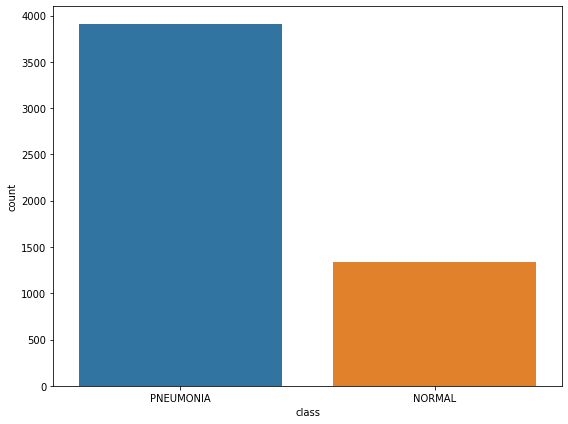

In [ ]:
## count number of images in each class for training data
DF = pd.DataFrame(columns=['class','count'])
DF['class']=pd.Series([os.listdir(train_folder)[x] for x in range(0,2)])
DF['count']=pd.Series([len(os.listdir(os.path.join(train_folder,os.listdir(train_folder)[x]))) for x in range(0,2)])
plt.figure(figsize=(8,6))
g=sns.barplot(x='class', y='count',data=DF)
g.set_xticklabels(g.get_xticklabels(), rotation=0)
plt.tight_layout()

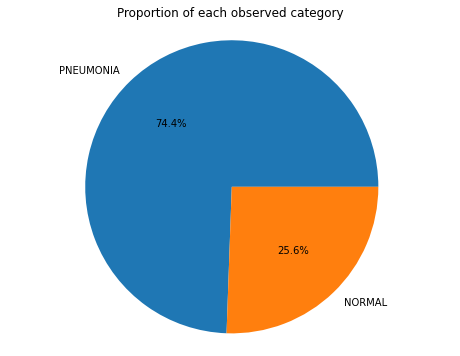

In [ ]:
plt.figure(figsize=(8,6))
plt.tight_layout()
plt.pie(DF['count'],
        labels=DF['class'],
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

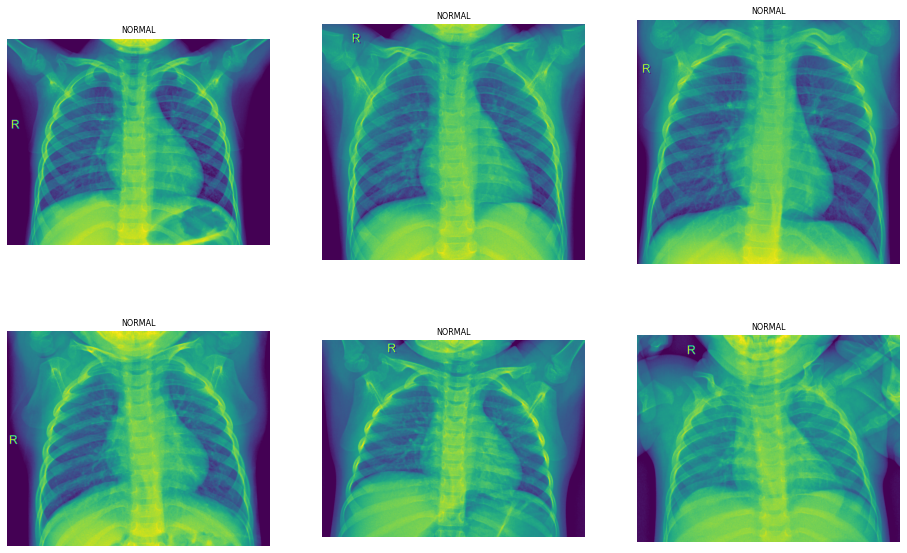

In [ ]:
import random
# visualize the Normal Class
W = 2
H = 3
fig, axes = plt.subplots(W, H, figsize = (16,10))

axes = axes.ravel() # flaten the matrix into array
for i in np.arange(0, W * H): 
    label ='NORMAL'
    class_dir = os.path.join(train_folder,label)
    # Select a random image
    image = random.choice(os.listdir(class_dir))
    # read and display an image with the selected index    
    img = plt.imread(os.path.join(class_dir,image))
    axes[i].imshow( img )
    axes[i].set_title(label, fontsize = 8) # the label
    axes[i].axis('off')

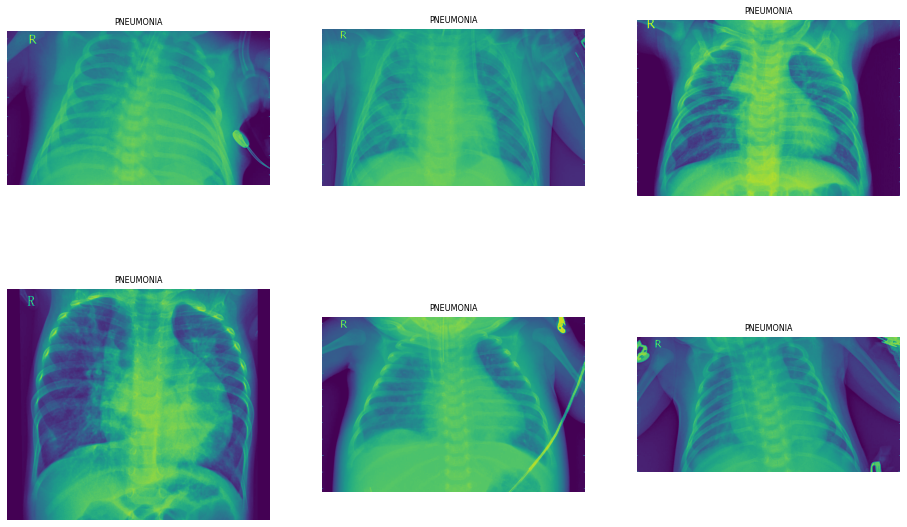

In [ ]:
# visualize the PNEUMONIA Class
W = 2
H = 3
fig, axes = plt.subplots(W, H, figsize = (16,10))

axes = axes.ravel() # flaten the matrix into array
for i in np.arange(0, W * H): 
    label ='PNEUMONIA'
    class_dir = os.path.join(train_folder,label)
    # Select a random image
    image = random.choice(os.listdir(class_dir))
    # read and display an image with the selected index    
    img = plt.imread(os.path.join(class_dir,image))
    axes[i].imshow( img )
    axes[i].set_title(label, fontsize = 8) # the label
    axes[i].axis('off')

In [ ]:
# from matplotlib.pyplot import figure
# import matplotlib.pyplot as plt
# plot_params = get_reset_plot_params()

# plot_params['figsize'] = (18,4)

# plot_params['title_fontsize'] = 13
# plot_params['label_fontsize'] = 10

# plot_params['title'] = "Number of Cases"

# plot_params['subplot'] = 131

# show_train_val_test(train_folder, val_folder, test_folder, plot_params)
# classes = os.listdir(train_folder)
# classes = [name_correct(i) for i in classes]

In [ ]:
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0,
                                   shear_range=0.2,
                                   vertical_flip=True,
                                   rotation_range=10,
                                   zoom_range=0.3)

# preprocessing the training dataset
training_dataset = train_datagen.flow_from_directory(train_folder,
                                                     classes=DETECTION_CLASSES,
                                                     shuffle=True,
                                                     batch_size=BATCH_SIZE,
                                                     target_size=(224, 224))

# data generator on test dataset, data augmentation not applied
# used as validation dataset as the val dir contains only 16 images
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# preprocessing the test dataset (used as validation)
test_dataset = test_datagen.flow_from_directory(test_folder,
                                                classes=DETECTION_CLASSES,
                                                shuffle=False,
                                                batch_size=BATCH_SIZE,
                                                target_size=(224, 224))

# data generator on validation dataset, data augmentation not applied
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# preprocessing the validation dataset
val_dataset = test_datagen.flow_from_directory(val_folder,
                                               classes=DETECTION_CLASSES,
                                               shuffle=False,
                                               batch_size=BATCH_SIZE,
                                               target_size=(224, 224))

Found 5245 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [ ]:
# printing the assigned indices for sanity check
print(f'class indices:  {training_dataset.class_indices}')

class indices:  {'NORMAL': 0, 'PNEUMONIA': 1}


In [ ]:
cnn_model = Sequential()

# First Block of CNN
cnn_model.add(Conv2D(16, (3, 3), padding='same', input_shape=(224, 224, 3), activation='relu'))
cnn_model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))

#  Second Block of CNN
cnn_model.add(SeparableConv2D(32, (3, 3), padding='same', activation='relu'))
cnn_model.add(SeparableConv2D(32, (3, 3), padding='same', activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2, 2)))

#  Third Block of CNN
cnn_model.add(SeparableConv2D(64, (3, 3), padding='same', activation='relu'))
cnn_model.add(SeparableConv2D(64, (3, 3), padding='same', activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2, 2)))

#  Fourth Block of CNN
cnn_model.add(SeparableConv2D(128, (3, 3), padding='same', activation='relu'))
cnn_model.add(SeparableConv2D(128, (3, 3), padding='same', activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Dropout(rate=0.2))

#  Fifth Block of CNN
cnn_model.add(SeparableConv2D(256, (3, 3), padding='same', activation='relu'))
cnn_model.add(SeparableConv2D(256, (3, 3), padding='same', activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Dropout(rate=0.2))

#  Flatten and Fully Connected Layer
cnn_model.add(Flatten())
cnn_model.add(Dense(units=512, activation='relu'))
cnn_model.add(Dropout(rate=0.7))
cnn_model.add(Dense(units=128, activation='relu'))
cnn_model.add(Dropout(rate=0.5))
cnn_model.add(Dense(units=64, activation='relu'))
cnn_model.add(Dropout(rate=0.3))

#  Softmax Classifier
cnn_model.add(Dense(units=2, activation='softmax'))

#  Display model
cnn_model.summary()

# compile model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Model: "sequential_2"
# cnn_model = Sequential()
# cnn_model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(64, 64, 3)))
# cnn_model.add(MaxPooling2D(pool_size = (2, 2)))
# cnn_model.add(Conv2D(16, (3, 3), activation="relu"))
# cnn_model.add(MaxPooling2D(pool_size = (2, 2)))
# cnn_model.add(Flatten())
# cnn_model.add(Dense(activation = 'relu', units = 128))
# cnn_model.add(Dense(activation = 'sigmoid', units = 1))
# cnn_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
# cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 separable_conv2d (Separable  (None, 112, 112, 32)     688       
 Conv2D)                                                         
                                                                 
 separable_conv2d_1 (Separab  (None, 112, 112, 32)     1344      
 leConv2D)                                                       
                                                        

In [ ]:
# cnn_model = cnn.fit(training_set,
#                     epochs = 2,
#                     validation_data = validation_set,
#                     )

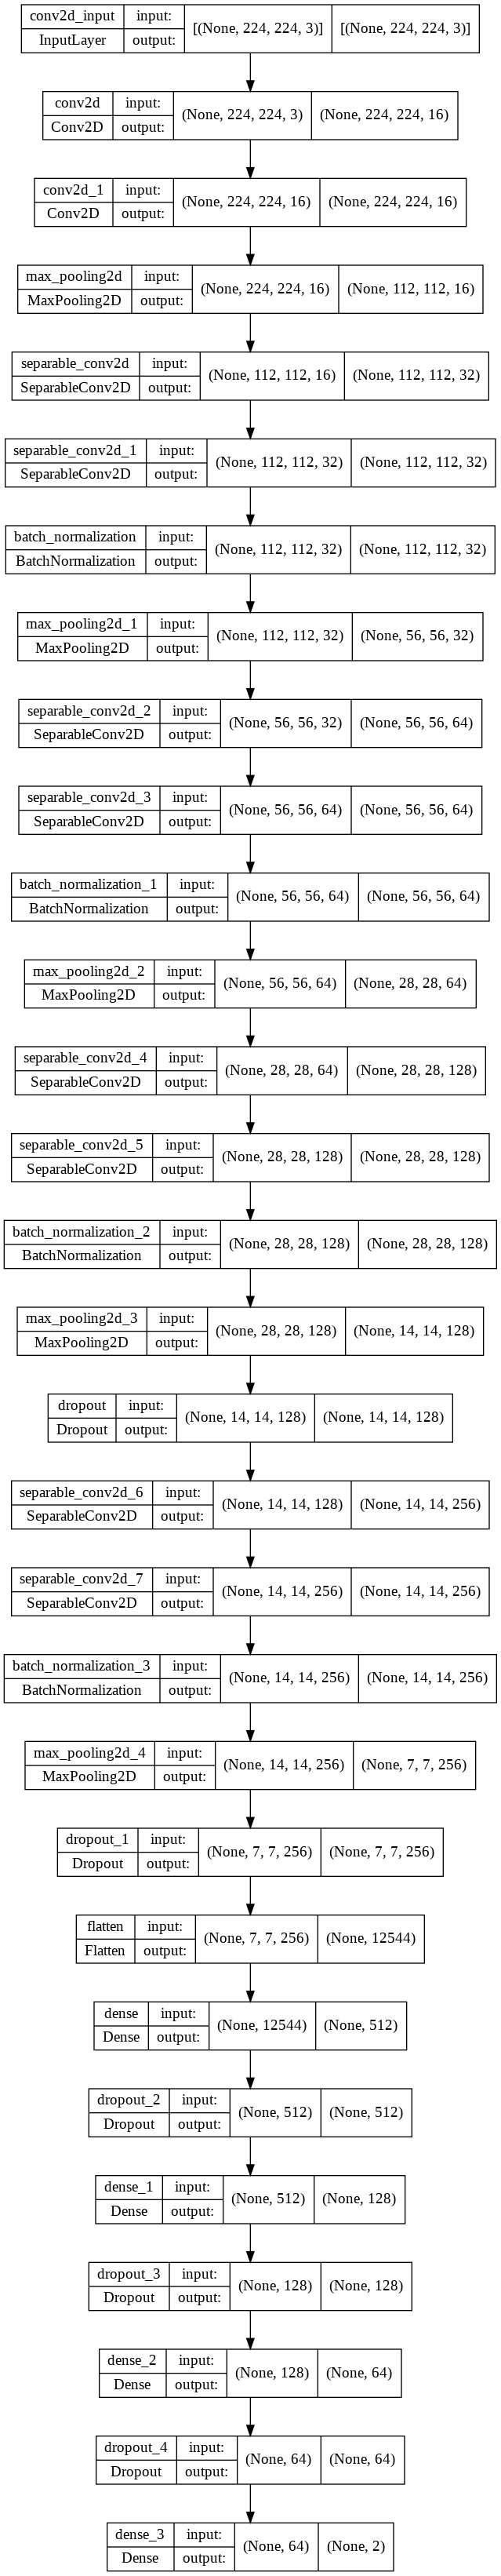

In [ ]:
plot_model(cnn_model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='cnn_model.png')

In [ ]:
# introducing callbacks
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           mode='min',
                           min_delta=0.001,
                           restore_best_weights=True)

checkpoint = ModelCheckpoint(filepath=MODEL_LOC,  # saves the 'best' model
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min')

In [ ]:
# fit the model
history = cnn_model.fit(training_dataset,
                        steps_per_epoch=len(training_dataset),
                        validation_data=test_dataset,
                        validation_steps=len(test_dataset),
                        epochs=EPOCHS,
                        callbacks=[early_stop, checkpoint],
                        verbose=1)

Epoch 1/5
164/164 [==============================] - 710s 4s/step - loss: 0.2288 - accuracy: 0.9035 - val_loss: 2.4699 - val_accuracy: 0.3750
Epoch 2/5
164/164 [==============================] - 690s 4s/step - loss: 0.2351 - accuracy: 0.9039 - val_loss: 1.2315 - val_accuracy: 0.6250
Epoch 3/5
164/164 [==============================] - 693s 4s/step - loss: 0.2230 - accuracy: 0.9110 - val_loss: 0.7565 - val_accuracy: 0.6426
Epoch 4/5
164/164 [==============================] - 689s 4s/step - loss: 0.2170 - accuracy: 0.9192 - val_loss: 2.4214 - val_accuracy: 0.3766
Epoch 5/5
164/164 [==============================] - 689s 4s/step - loss: 0.1905 - accuracy: 0.9232 - val_loss: 1.7061 - val_accuracy: 0.4071


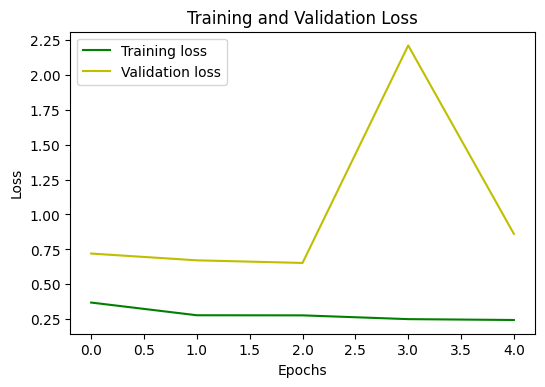

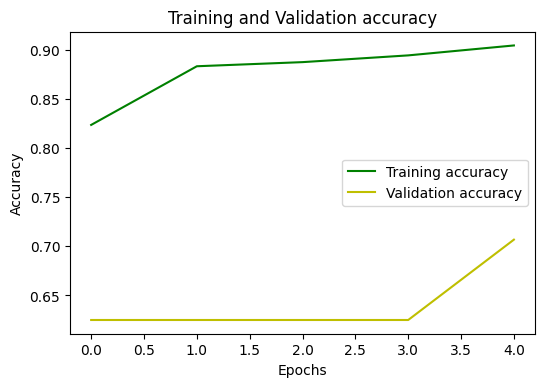

In [ ]:
## plot loss for train and Validation
loss_train = history.history['loss']
loss_val = history.history['val_loss']
plt.figure(figsize=(6,4), dpi=100)
plt.plot(loss_train, 'g', label = 'Training loss')
plt.plot(loss_val, 'y', label = 'Validation loss')
plt.title("Training and Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## plot loss for train and Validation
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
plt.figure(figsize=(6,4), dpi=100)
plt.plot( loss_train, 'g', label = 'Training accuracy')
plt.plot( loss_val, 'y', label = 'Validation accuracy')
plt.title("Training and Validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# MODEL_LOC = '../model/pneumonia_detection_cnn_model.h5'
# load the trained CNN model
cnn_model = load_model(MODEL_LOC)
# storing the true classes of the test dataset
y_true = test_dataset.classes

# predicting the classes of the test dataset
y_pred = cnn_model.predict(test_dataset, steps=len(test_dataset), verbose=1)

# Storing the predicted probability
y_pred_prob = y_pred[:, 1]

# Storing the binary classes for the predictions
y_pred_binary = y_pred_prob > 0.5

20/20 [==============================] - 26s 1s/step


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, \
classification_report, roc_auc_score, roc_curve

In [ ]:
# confusion matrix for test dataset 
print('\nConfusion Matrix for Test Dataset\n -------------------------')
cm = confusion_matrix(y_true, y_pred_binary)
print(cm)


Confusion Matrix for Test Dataset
 -------------------------
[[  0 234]
 [  0 390]]


Text(0.5, 1.0, 'Confusion Matrix for Test Dataset')

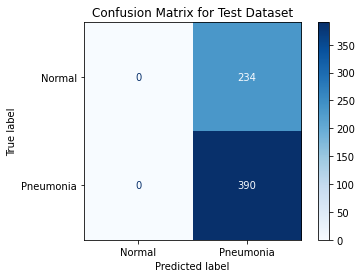

In [ ]:
cm_display = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Pneumonia'])
cm_display.plot(cmap = 'Blues')
plt.title('Confusion Matrix for Test Dataset')

In [ ]:
# classification report
# accuracy: (tp + tn) / (p + n)
# precision tp / (tp + fp)
# recall: tp / (tp + fn)
# f1_score: 2 tp / (2 tp + fp + fn)
print('\nClassification Report\n -------------------------')
print(classification_report(y_true, y_pred_binary))


Classification Report
 -------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       234
           1       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# ROC AUC
auc = roc_auc_score(y_true, y_pred_prob)
print(f'ROC AUC (Test Dataset) {auc:.2}')

ROC AUC (Test Dataset) 0.91


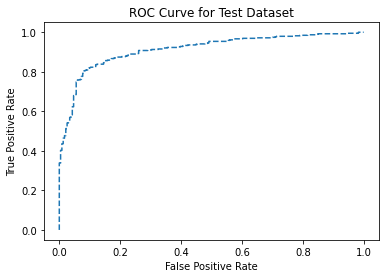

In [ ]:
# calculate roc curves
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)

# plot the roc curve for the model
plt.figure()
plt.plot(fpr, tpr, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Dataset')
plt.show()

In [ ]:
# storing the true classes of the test dataset
y_true_val = val_dataset.classes

# predicting the classes of the test dataset
y_pred_val = cnn_model.predict(val_dataset, steps=len(val_dataset), verbose=1)

# Storing the predicted probability
y_pred_val_prob = y_pred_val[:, 1]

# Storing the binary classes for the predictions
y_pred_val_binary = y_pred_val_prob > 0.5

1/1 [==============================] - 1s 692ms/step



Confusion Matrix for Validation Dataset
 -------------------------
[[0 8]
 [0 8]]


Text(0.5, 1.0, 'Confusion Matrix for Validation Dataset')

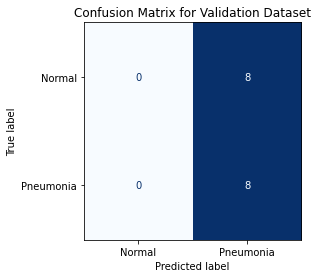

In [ ]:
# confusion matrix for validation dataset 
print('\nConfusion Matrix for Validation Dataset\n -------------------------')
cm_val = confusion_matrix(y_true_val, y_pred_val_binary)
print(cm_val)

cm_display_val = ConfusionMatrixDisplay(cm_val, display_labels=['Normal', 'Pneumonia'])
cm_display_val.plot(cmap='Blues', colorbar=False)
plt.title('Confusion Matrix for Validation Dataset')